In [47]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sys import exit
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
import statsmodels.regression.linear_model as sm
from sklearn.ensemble import GradientBoostingRegressor
import datetime

    
df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv",encoding = "ISO-8859-1")

filter=df["state"].isin(['Colorado','Idaho','Utah'])
#filter=df["state"].isin(['Utah'])
df=df[filter]
filter=df["date"]>='2020-04-01'
df=df[filter]
df=df.sort_values(['county'],ascending=True)
print("deaths by county " +str(df.groupby(["state","county",'date'])["cases","deaths"].agg([max])))



deaths by county                            cases deaths
                             max    max
state    county date                   
Colorado Adams  2020-04-01   214      6
                2020-04-02   260      7
                2020-04-03   294      9
                2020-04-04   320      9
                2020-04-05   354     10
...                          ...    ...
Utah     Weber  2020-04-20   119      1
                2020-04-21   119      1
                2020-04-22   125      1
                2020-04-23   131      2
                2020-04-24   132      2

[2661 rows x 2 columns]


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


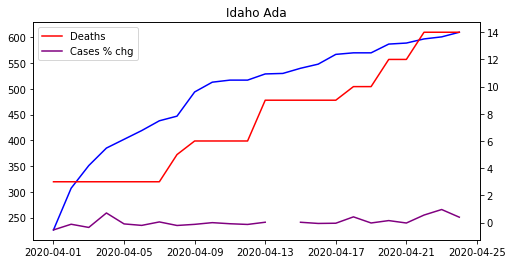

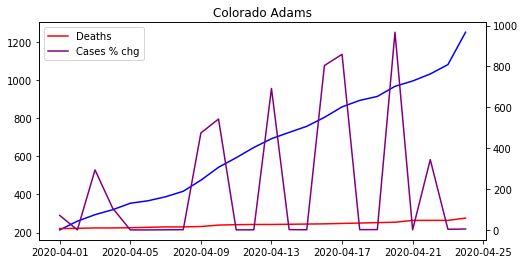

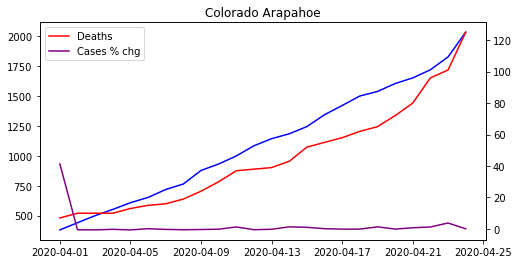

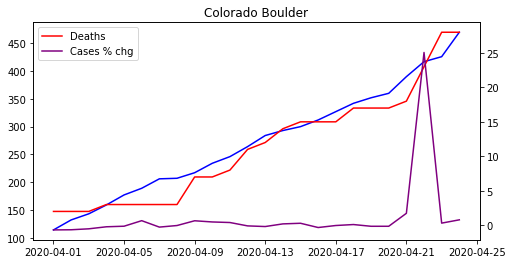

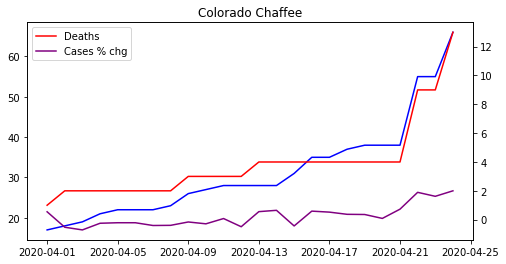

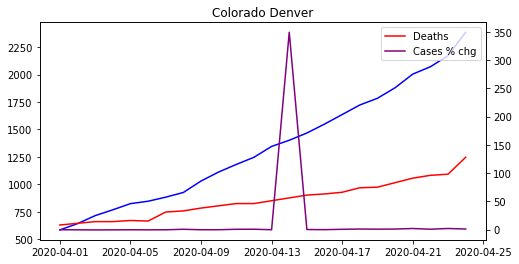

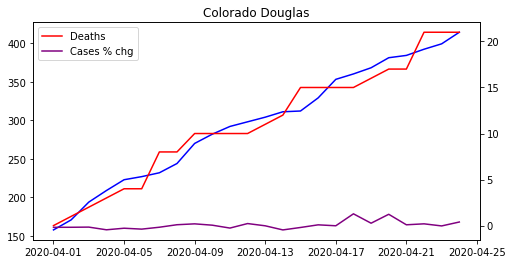

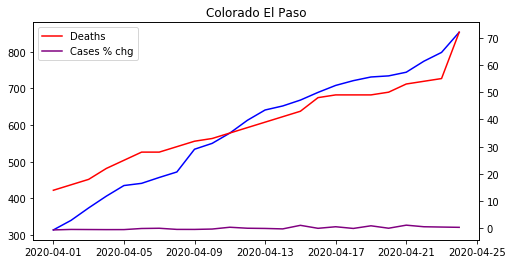

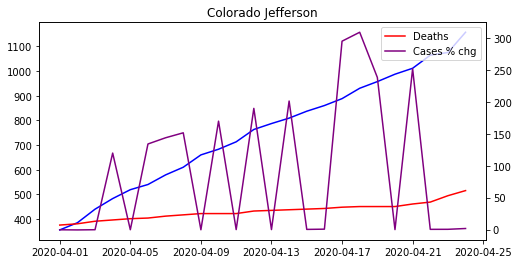

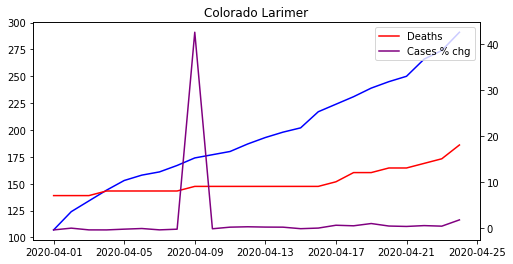

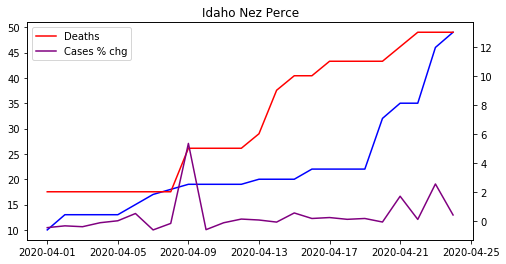

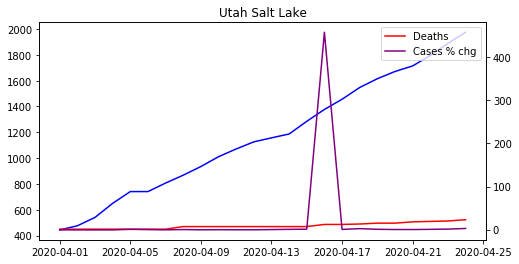

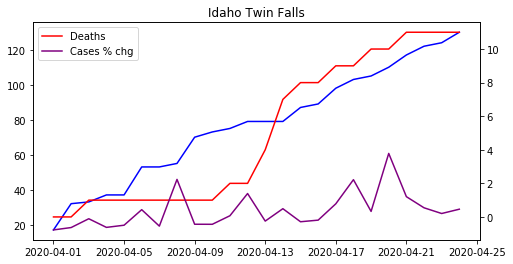

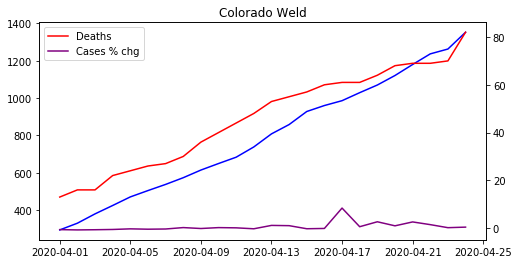

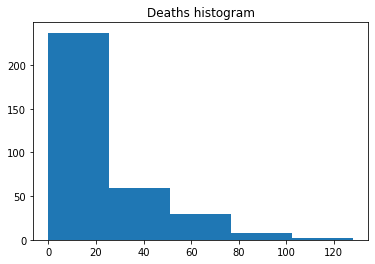

C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


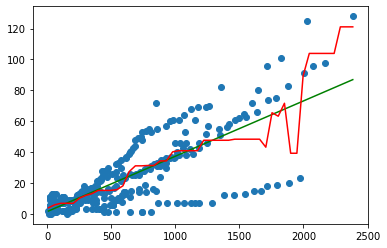

In [72]:
#results=df.pivot_table(index=["state","county"],columns='date', values=['deaths','cases'],fill_value=0)
#df_results=pd.DataFrame(results.to_records())
#plt.clf()
#results.plot(kind="scatter", 
#             x="cases",
#             y="deaths",
#             title="cases by deaths",rot=45)
#plt.xticks(rotation=45, ha='right')
#plt.show()

df['state_county']=df['state']+" "+df['county']
df['cases_pct_change']=df['cases'].pct_change()
deaths=df['deaths'].tolist()
cases=df['cases'].tolist()
counties=df['county'].tolist()
counties_filter=df.groupby(['state','county'])['deaths'].max()>10
counties_filter=counties_filter.loc[counties_filter.values==True]
counties=pd.merge(df,counties_filter,how='inner',on=['state','county'])
counties_df=counties[counties['deaths_y']==True]
counties_unique=counties_df['state_county'].unique()

rows=len(counties_unique)

index=0
deaths=[]
cases=[]
cases_pct_change=[]
index_date=[]

for item in counties_unique:
    subset_df=df[df['state_county']==item]
    dates=pd.to_datetime(subset_df['date']).dt.date
    dates=dates.unique()
    
    index=0
    for date in dates:
        subset_df=df[(df['state_county']==item) & (df['date']==str(date)) ]
        result=subset_df.groupby('date')['deaths'].first()
        value=result[0]
        deaths.append(value)
        
        result=subset_df.groupby('date')['cases'].first()
        value=result[0]
        cases.append(value)
        
        result=subset_df.groupby('date')['cases_pct_change'].first()
        value=result[0]
        cases_pct_change.append(value)

        index_date.append(date)

    dict={
        'deaths':deaths,
        'cases':cases,
        'cases_pct_change':cases_pct_change,
        'date':index_date
    }
    df_summary=pd.DataFrame(dict)
    df_summary=df_summary.sort_values('date')
    #print(df_summary)
    
    fig,ax = plt.subplots(figsize=(8,4))
    ax.plot(df_summary['date'],df_summary['cases'],color='blue',label='Cases')
    ax2=ax.twinx()
    ax2.plot(df_summary['date'],df_summary['deaths'],color='red',label='Deaths')
    ax2.plot(df_summary['date'],df_summary['cases_pct_change'],color='purple',label='Cases % chg')
    
    index+=1
    ax.set_title(item)
    deaths.clear()
    cases.clear()
    cases_pct_change.clear()
    index_date.clear()
    plt.legend()  
    plt.show()

deaths_unique=counties_df.groupby(['county','date'])['deaths_x'].max()
cases_unique =counties_df.groupby(['county','date'])['cases'].max()
counties_unique=counties_df['county'].unique()

plt.hist(deaths_unique,bins=5)
plt.title('Deaths histogram')
plt.xlabel='occurrences'
plt.ylabel='deaths'

plt.show()

X_cases=np.array(cases_unique).reshape(-1,1)
y_deaths=np.array(deaths_unique).reshape(-1,1)
prediction_space=np.linspace(min(X_cases),max(X_cases)).reshape(-1,1)

model = linear_model.LinearRegression()
model.fit(X_cases, y_deaths)

SEED=1
gbt=GradientBoostingRegressor(n_estimators=300, max_depth=1, random_state=SEED)
gbt.fit(X_cases, y_deaths)  

prediction_space=np.linspace(min(X_cases),max(X_cases)).reshape(-1,1)

plt.clf()
plt.scatter(cases_unique,deaths_unique)
plt.plot(prediction_space,model.predict(prediction_space),c="green")

plt.plot(prediction_space,gbt.predict(prediction_space),c="red")
plt.xlabel='deaths'
plt.ylabel='cases'
plt.show()



In [66]:
#print(dates)
start_date=dates.min()

#start = '1/22/2020'
#start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]

for i in range(len(future_forecast)):
    future_forecast_dates.append(
        (start_date + datetime.timedelta(days=i)
        ).strftime('%m/%d/%Y'))
    
#print(future_forecast_dates)
#print(adjusted_dates)